In [1]:
## SET UP OF NOTEBOOK
# import necessary modules
import pandas as pd
import numpy as np
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
import scanpy as ad


In [2]:
input_path = "/disk2/user/hilpek/project_root/scRNAseq/input/"
output_path = "/disk2/user/hilpek/project_root/scRNAseq/output/"

In [3]:
# Read input files into an AnnData object
adata = ad.read_h5ad(os.path.join(input_path, 'Wu_all_NT.h5ad'))

In [4]:
# Removed HER samples.
adata = adata[(adata.obs['IHC_subtype'] == 'ER+'), :]

In [5]:
# mt and ribo columns have been added to adata.var
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
adata.var['ribo'] = adata.var_names.str.upper().str.startswith(('RPL', 'RPS'))

/tmp/ipykernel_255131/3948233417.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')


In [6]:
# adata.obsm['mt'] → Mitochondrial gene ratio of each cell
# adata.obsm['ribo'] → Ribosomal gene ratio of each cell

In [7]:
## DATA EXPLORATION
# The obtained AnnData object
adata

AnnData object with n_obs × n_vars = 33790 × 29733
    obs: 'Study_id', 'Celltype_subset', 'bc_subtype', 'donor_age', 'treatment_status', 'grade', 'IHC_subtype', 'Dataset'
    var: 'ENSEMBL', 'mt', 'ribo'

In [8]:
# Cell Informatıon(adata.obs)
adata.obs

,Study_id,Celltype_subset,bc_subtype,donor_age,treatment_status,grade,IHC_subtype,Dataset
CID3941_AAAGTAGTCCTTGCCA,CID3941,Endothelial ACKR1,IDC,50.0,Naive,2.0,ER+,CID3941
CID3941_ACAGCCGAGCTCTCGG,CID3941,Endothelial ACKR1,IDC,50.0,Naive,2.0,ER+,CID3941
CID3941_ACGCAGCAGGACCACA,CID3941,Endothelial ACKR1,IDC,50.0,Naive,2.0,ER+,CID3941
CID3941_ACGCAGCCAGCTGTAT,CID3941,Endothelial ACKR1,IDC,50.0,Naive,2.0,ER+,CID3941
CID3941_ACTTTCACAGCCTGTG,CID3941,Endothelial ACKR1,IDC,50.0,Naive,2.0,ER+,CID3941
...,...,...,...,...,...,...,...,...
CID4535_TAGTGGTCATTGGCGC,CID4535,Mature Luminal,ILC,47.0,Naive,2.0,ER+,CID4535
CID4535_TCTATTGAGCTAGGCA,CID4535,Mature Luminal,ILC,47.0,Naive,2.0,ER+,CID4535
CID4535_TGCTACCAGGTGTGGT,CID4535,Mature Luminal,ILC,47.0,Naive,2.0,ER+,CID4535
CID4535_TGGCCAGAGCCCAACC,CID4535,Mature Luminal,ILC,47.0,Naive,2.0,ER+,CID4535


In [9]:
are_equal = np.array_equal(adata.obs['Study_id'].values, adata.obs['Dataset'].values)
if are_equal:
    print("Study_id and Dataset columns are identical.")

Study_id and Dataset columns are identical.


In [10]:
print("Case IDs present in the data:")
for id in adata.obs['Study_id'].unique():
    print(id)

Case IDs present in the data:
CID3941
CID3948
CID4040
CID4067
CID4290A
CID4461
CID4463
CID4471
CID4530N
CID4535


 Note: All samples are untreated ER+ samples. CID4471 and CID4535 are ILC, and the rest are IDC.

In [11]:
# Gene Information (adata.var)
adata.var

,ENSEMBL,mt,ribo
RP11-34P13.7,ENSGX0000000001,False,False
FO538757.3,ENSGX0000000002,False,False
FO538757.2,ENSGX0000000003,False,False
AP006222.2,ENSGX0000000004,False,False
RP4-669L17.10,ENSGX0000000005,False,False
...,...,...,...
RP11-983C2.3,ENSGX0000010212,False,False
LINC00919,ENSG00000260268,False,False
RP11-589P10.7,ENSGX0000010213,False,False
KRTAP9-2,ENSG00000262573,False,False


Note: The gene names in the format "ENSG X ..." are genes that were failed to be mapped to a known gene ID. They will need to be filtered out later in the analysis.

In [12]:
# Remove mt and ribo genes.
adata = adata[:, ~(adata.var["mt"] | adata.var["ribo"])].copy()

In [13]:
print("mt gene count:", sum(adata.var["mt"]))
print("ribo gene count:", sum(adata.var["ribo"]))

mt gene count: 0
ribo gene count: 0


In [14]:
adata.var[adata.var["mt"]==True]

,ENSEMBL,mt,ribo


In [15]:
adata.var[adata.var["ribo"]==True]

,ENSEMBL,mt,ribo


In [16]:
adata.var[(adata.var["ribo"]==True) & (adata.var["mt"]==True)]

,ENSEMBL,mt,ribo


It appears that there are no mitochondrial or ribosomal genes present in the data.

In [17]:
## COMMON QC METRICS
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace=True)
adata

AnnData object with n_obs × n_vars = 33790 × 29618
    obs: 'Study_id', 'Celltype_subset', 'bc_subtype', 'donor_age', 'treatment_status', 'grade', 'IHC_subtype', 'Dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'ENSEMBL', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

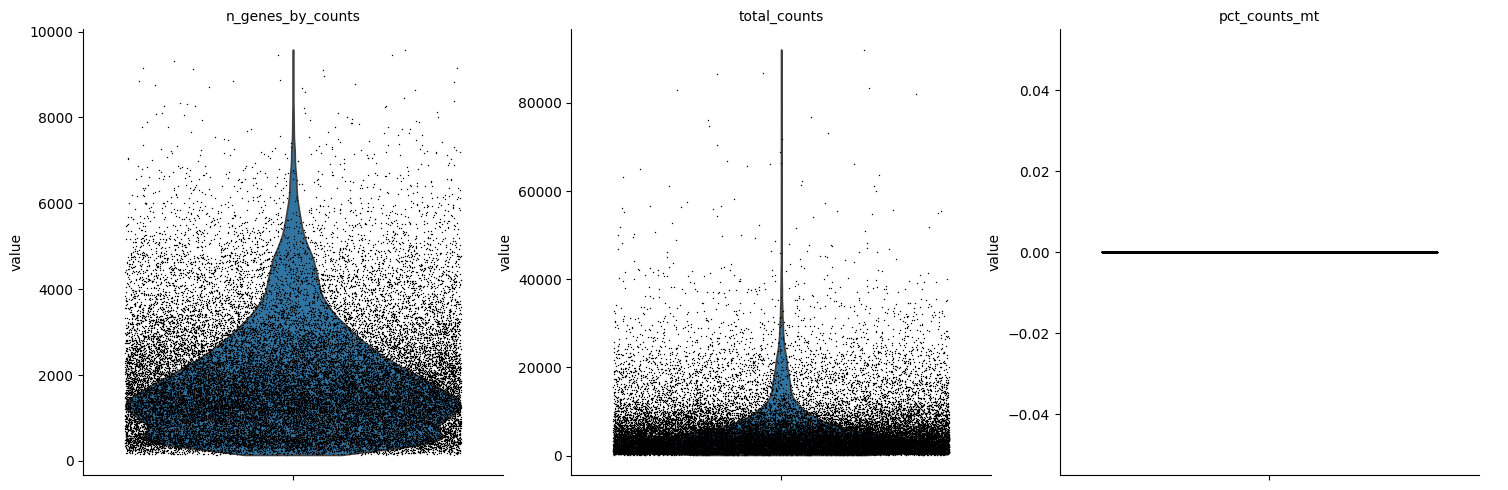

In [18]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

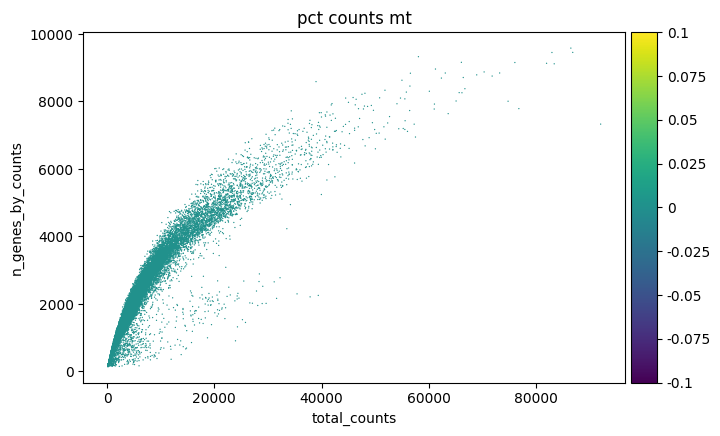

In [19]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [20]:
# Preprocessing
# Quality Control

Metrics were calculated separately for each sample because they could require varying QC thresholds separately.

sample id: CID3941


/disk2/user/hilpek/venv/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


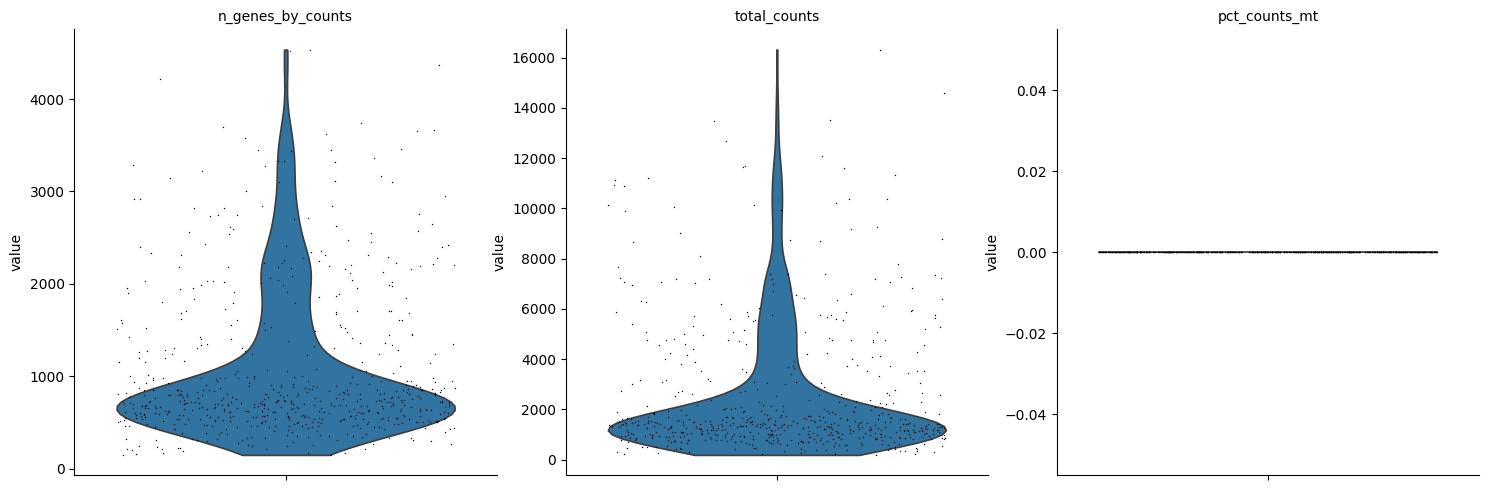

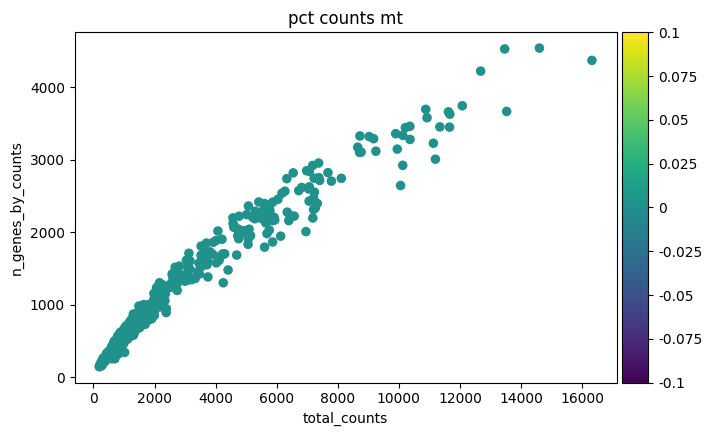


sample id: CID3948


/disk2/user/hilpek/venv/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


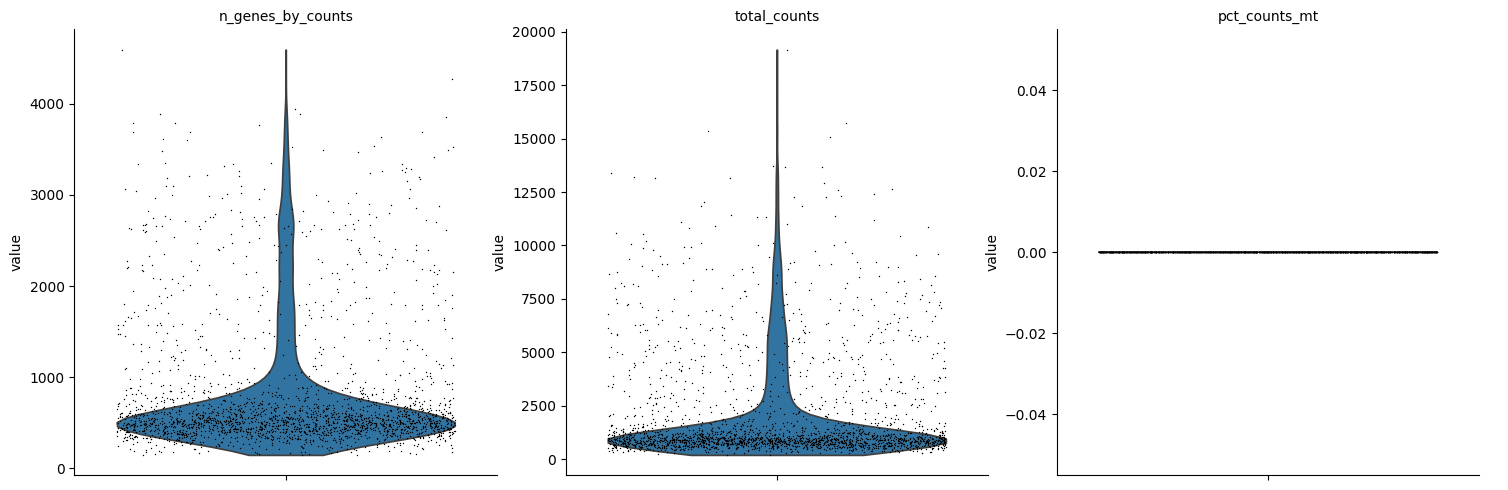

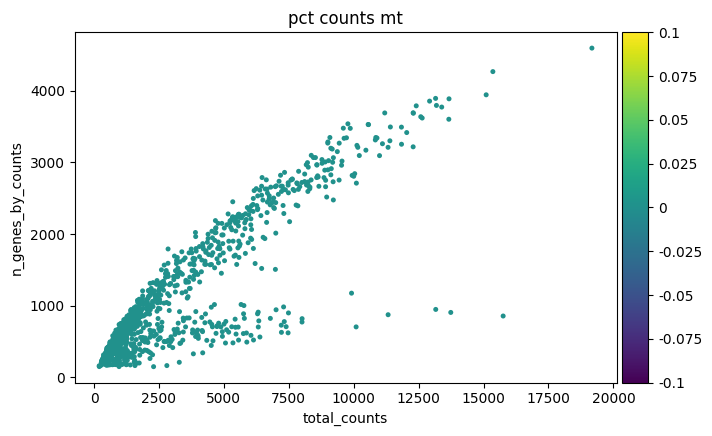


sample id: CID4040


/disk2/user/hilpek/venv/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


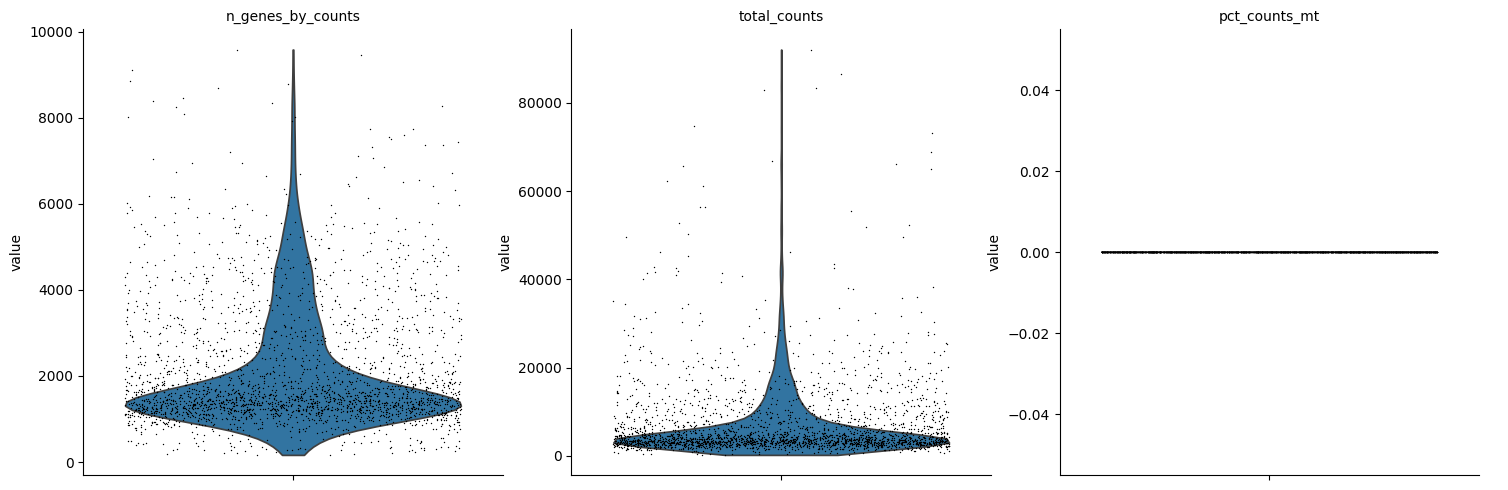

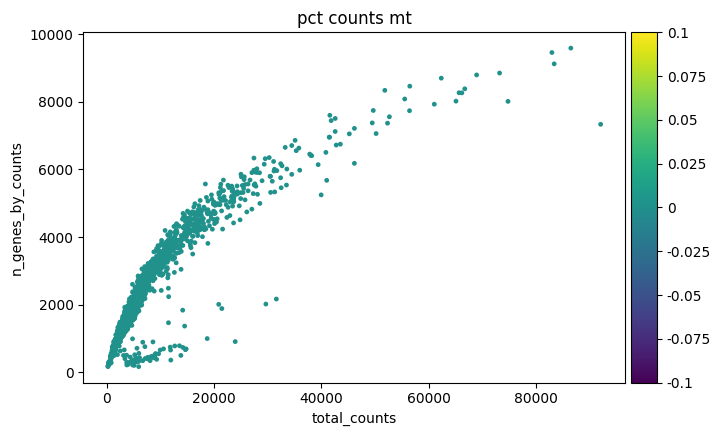


sample id: CID4067


/disk2/user/hilpek/venv/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


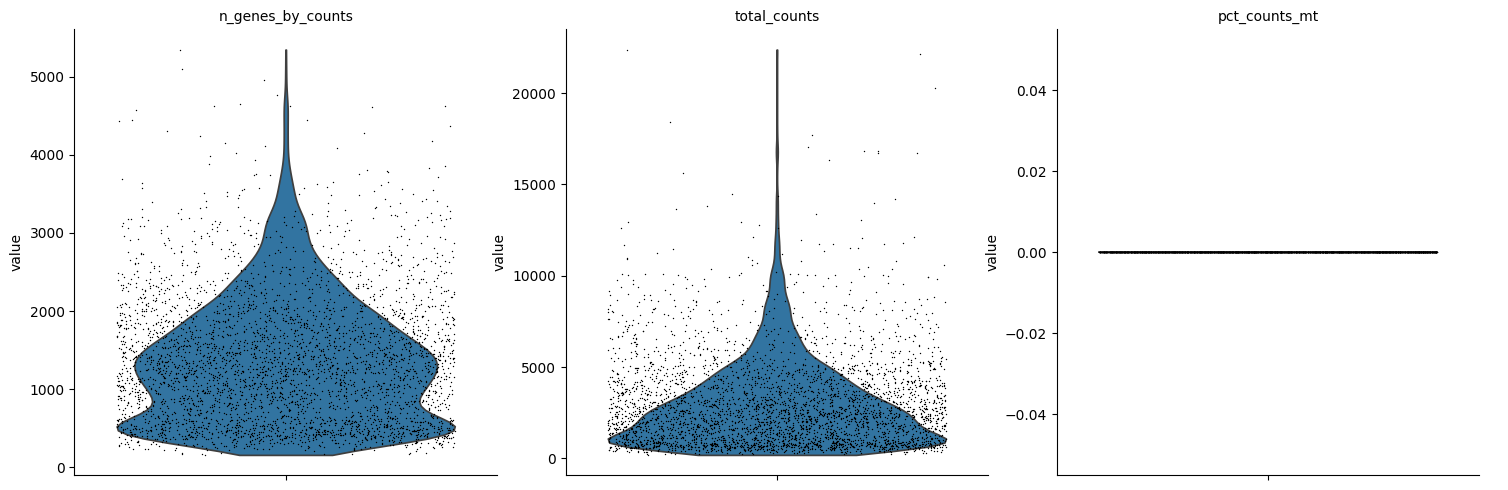

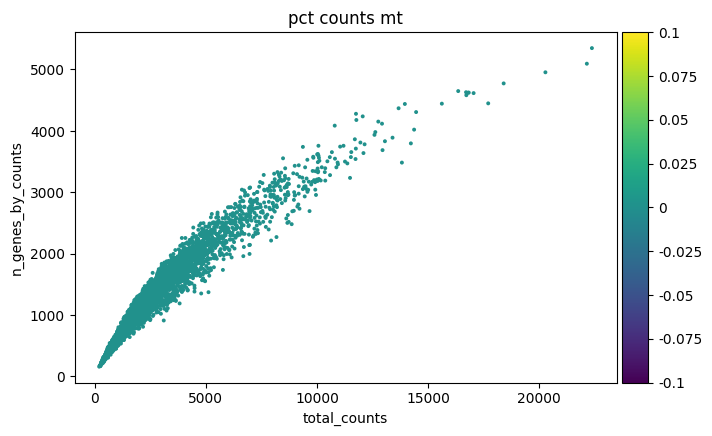


sample id: CID4290A


/disk2/user/hilpek/venv/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


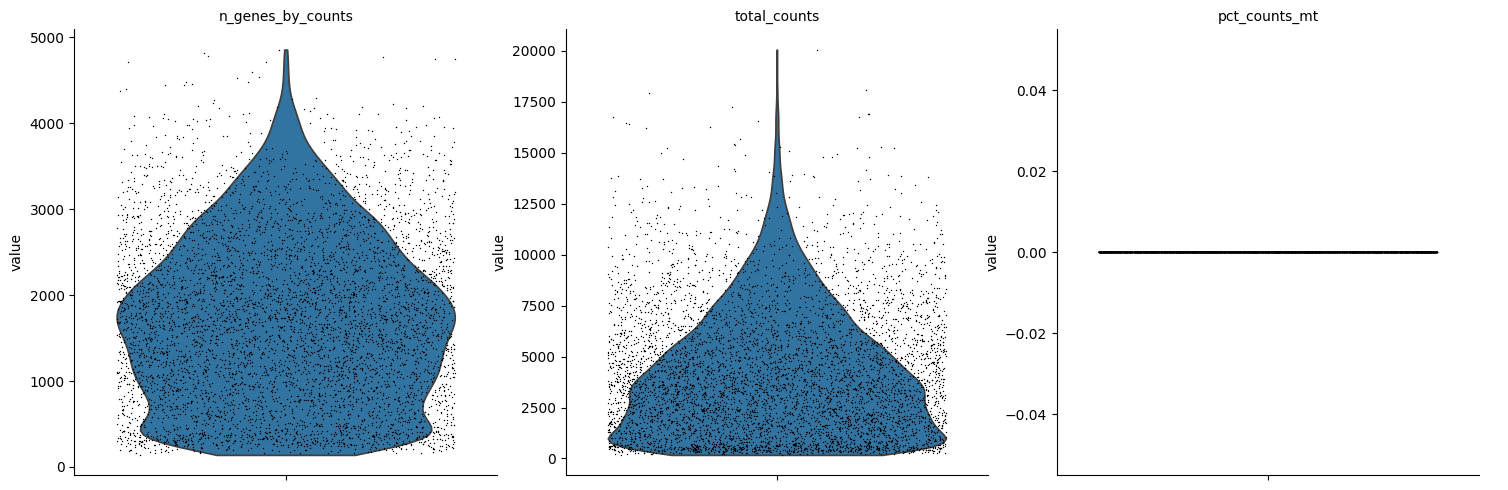

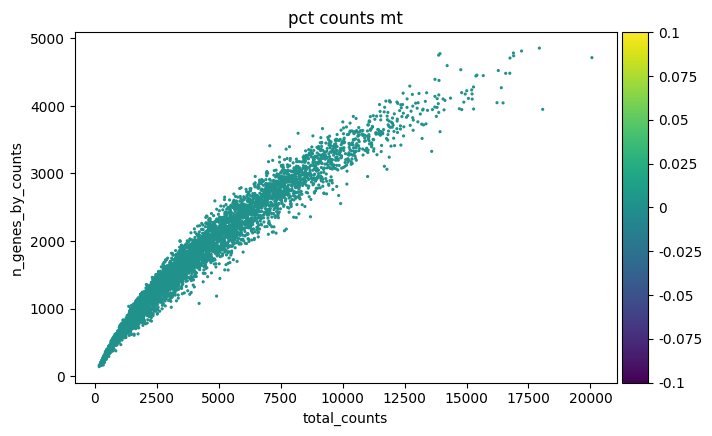


sample id: CID4461


/disk2/user/hilpek/venv/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


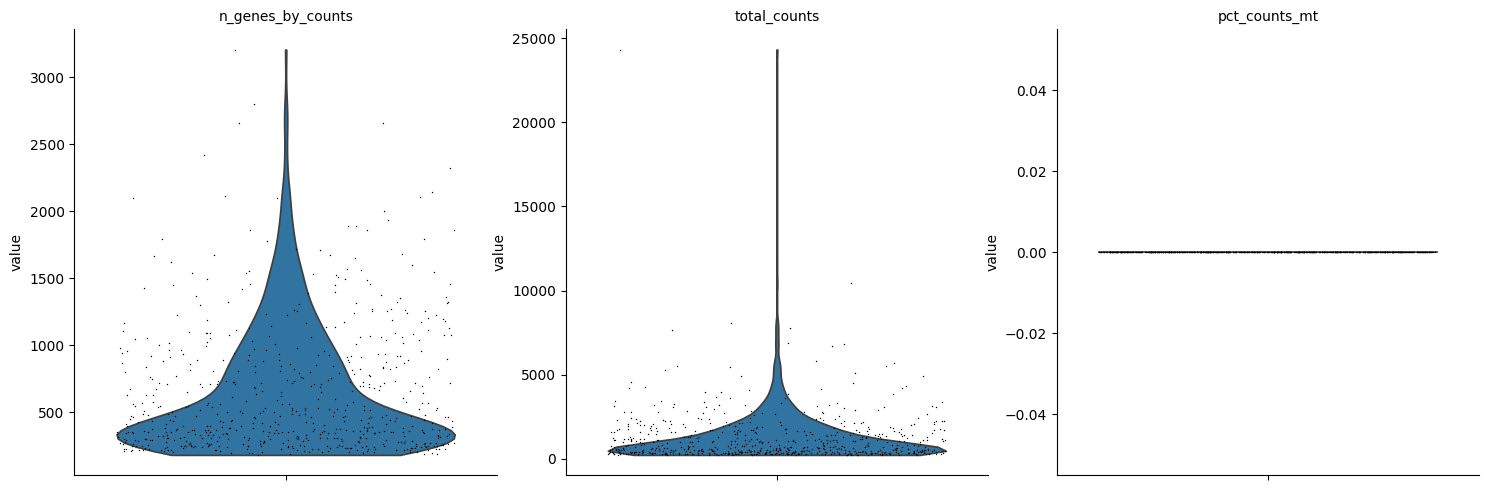

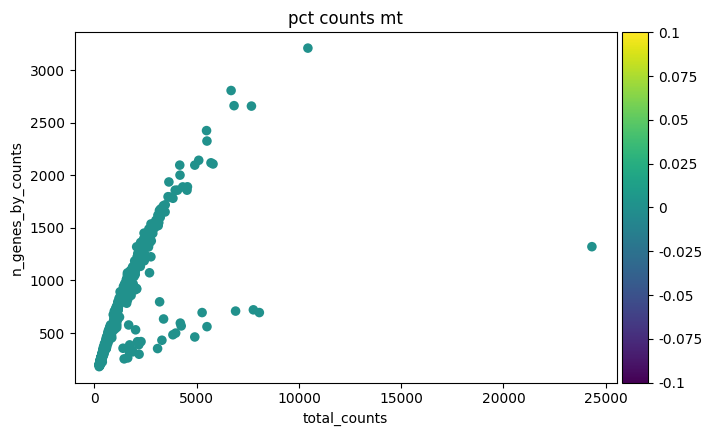


sample id: CID4463


/disk2/user/hilpek/venv/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


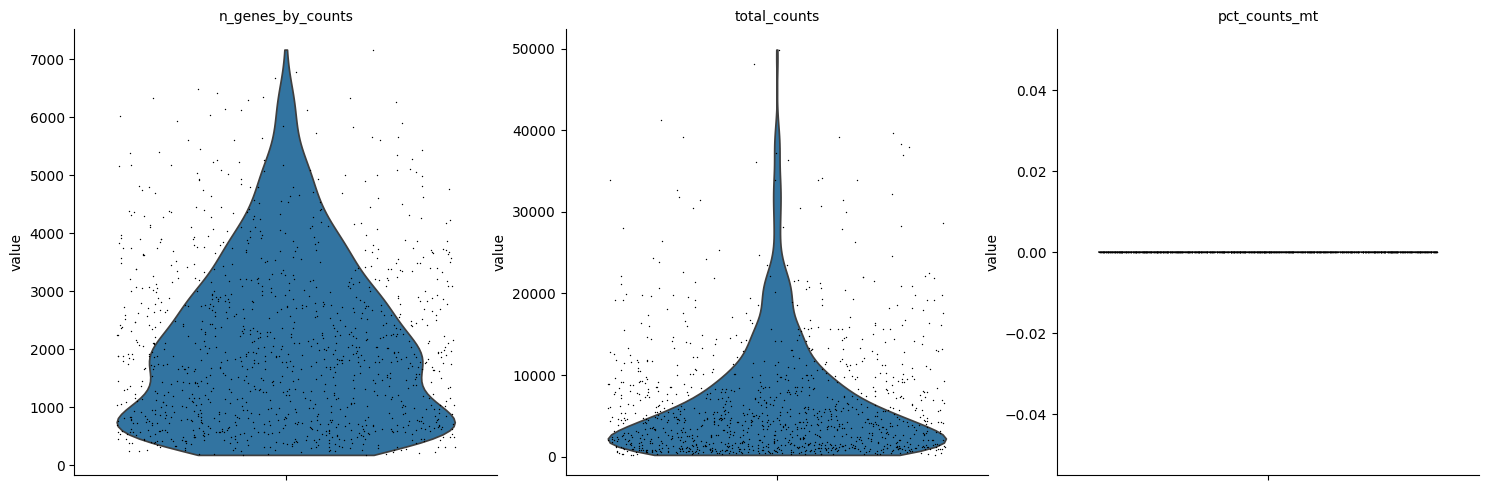

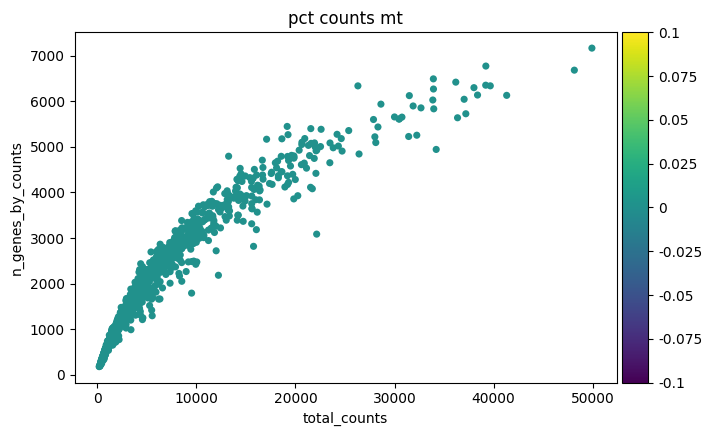


sample id: CID4471


/disk2/user/hilpek/venv/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


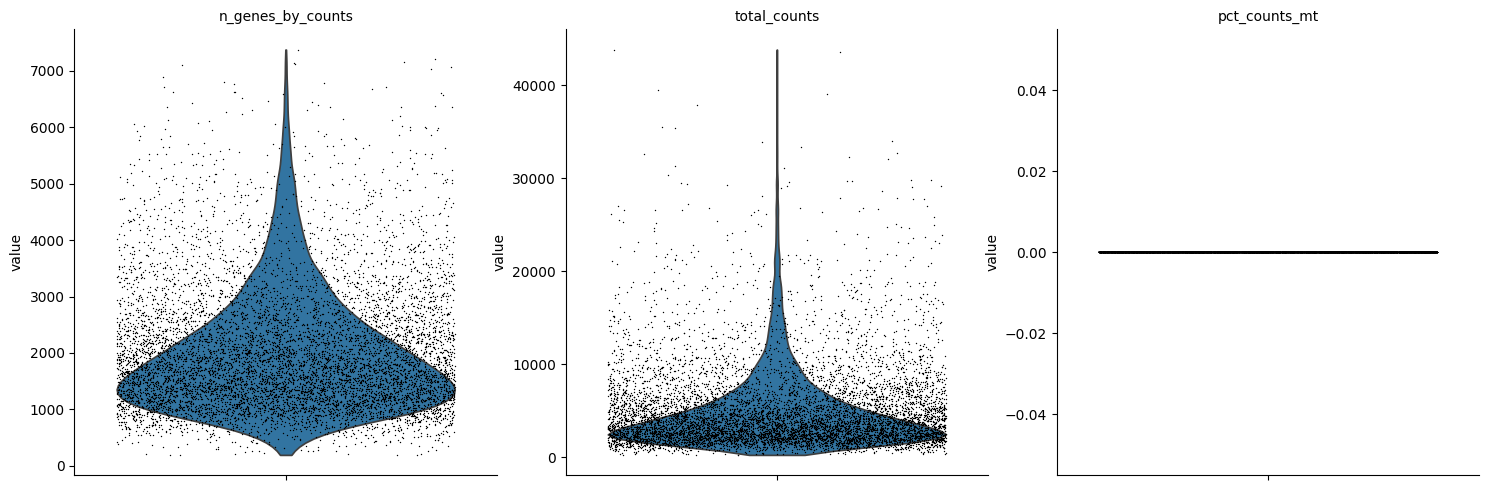

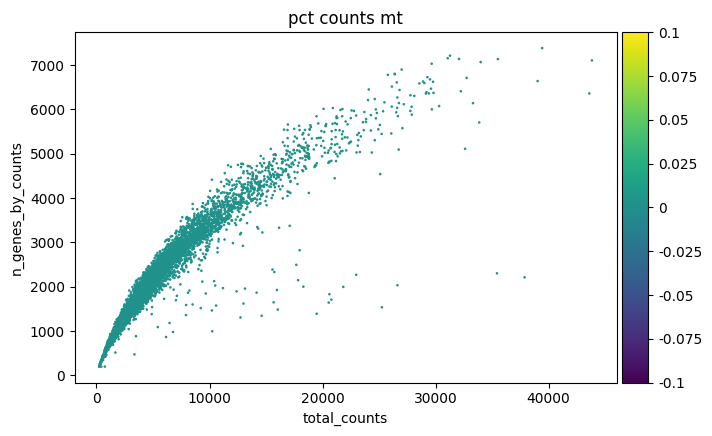


sample id: CID4530N


/disk2/user/hilpek/venv/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


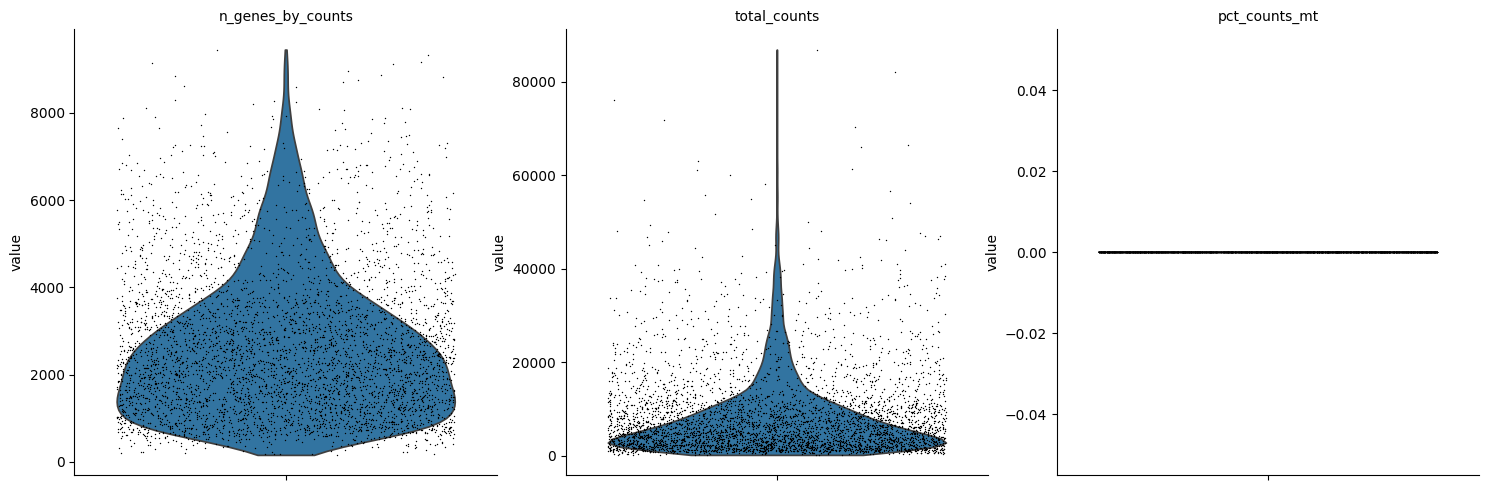

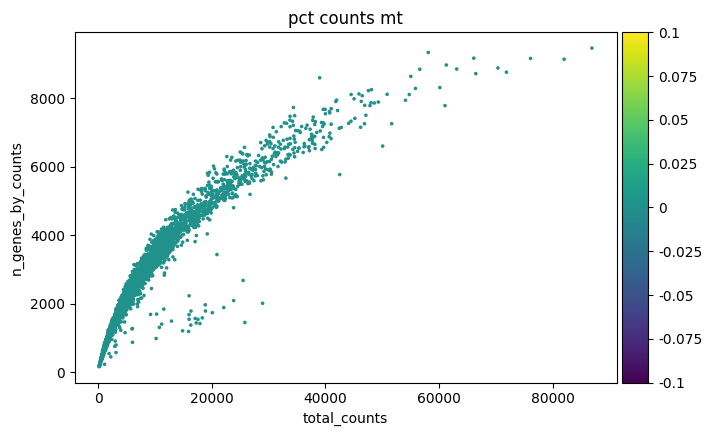


sample id: CID4535


/disk2/user/hilpek/venv/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


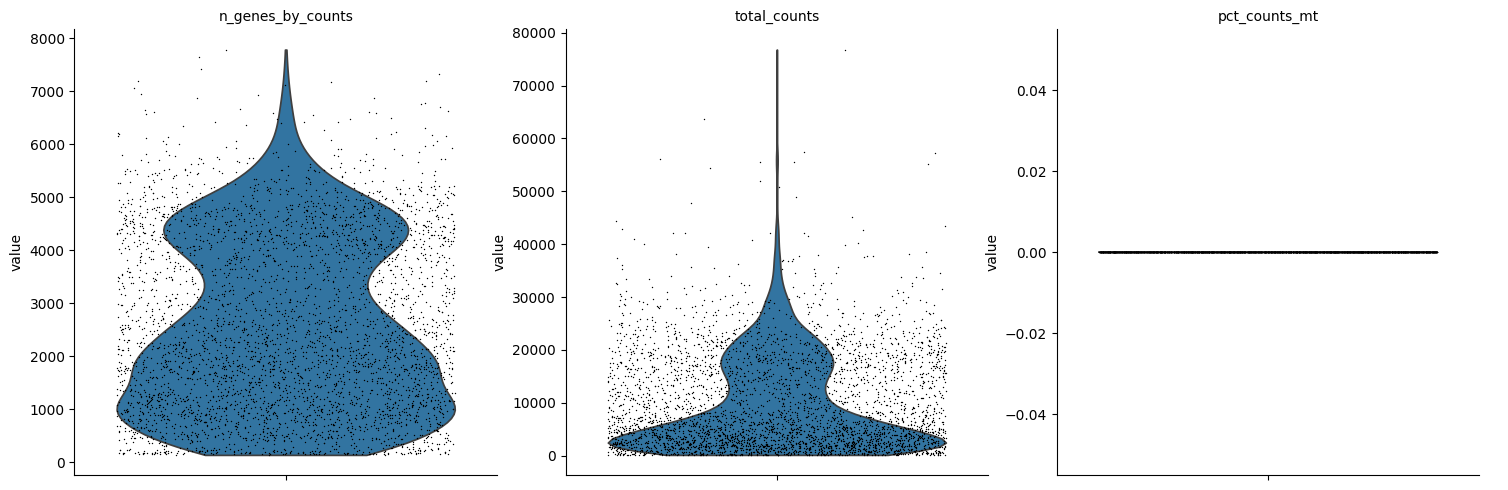

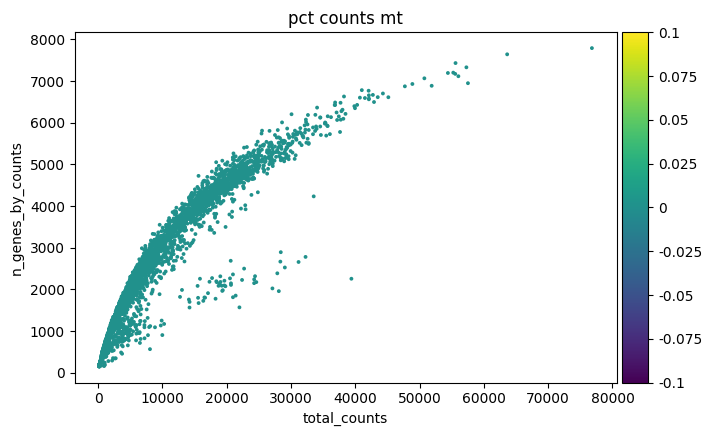

In [21]:
for sample in adata.obs["Study_id"].unique():
    filtered_adata = adata[adata.obs['Study_id'] == sample]
    print("sample id:", sample)
    sc.pp.calculate_qc_metrics(filtered_adata, qc_vars = ["mt"], inplace=True)
    sc.pl.violin(
        filtered_adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
    )
    sc.pl.scatter(filtered_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
    print() 

In [22]:
adata

AnnData object with n_obs × n_vars = 33790 × 29618
    obs: 'Study_id', 'Celltype_subset', 'bc_subtype', 'donor_age', 'treatment_status', 'grade', 'IHC_subtype', 'Dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'ENSEMBL', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [23]:
filtered_adata

AnnData object with n_obs × n_vars = 3961 × 29618
    obs: 'Study_id', 'Celltype_subset', 'bc_subtype', 'donor_age', 'treatment_status', 'grade', 'IHC_subtype', 'Dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'ENSEMBL', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [24]:
adata.write("filtered_reference.h5ad")

### Export adata from Python as .mtx and .csv

In [25]:
# Save the count matrix in Matrix Market (.mtx) format
from scipy.io import mmwrite
import scipy.sparse
import pandas as pd

# If not already sparse, convert to sparse format
from scipy.sparse import csr_matrix
counts_sparse = csr_matrix(adata.X)

# Save as Matrix Market file (genes x cells)
mmwrite("reference_counts.mtx", counts_sparse) 


In [26]:
# Save the cell type annotations as .csv
# Save cell type labels for each cell
adata.obs[["Celltype_subset"]].to_csv("celltypes.csv")

In [27]:
# save gene and cell names (helpful for debugging or reference)
# Save cell names
pd.Series(adata.obs_names).to_csv("cell_names.csv", index=False, header=False)

# Save gene names
pd.Series(adata.var_names).to_csv("gene_names.csv", index=False, header=False)
